In [1]:
## Packages
'''Import all the necessary packages and modules'''

import numpy as np # package for playing with matrices
from scipy import signal as ss
import matplotlib.pyplot as plt
import sys, os # python modules for interacting with computer
from tkinter import filedialog # interface for opening a file explorer
from tkinter import * # * imports all files in tkinter 
import pandas as pd # useful for keeping cell structure and 2d data manipulation
import glob # helps find path 

In [2]:
## Functions
''' Run cell to use functions'''
def normalize(raw):
    norm=[]
    for i in raw:
        if i<0:
            norm.append(-i/min(raw))
        elif i>0:
            norm.append(i/max(raw))
        else:
            norm.append(i)
    return norm
def lowpass_filter(YA,sample_range,filter_size): #YA data set, measured sample range, filter_size arbitrary frequency cutoff based on number of samples
                   
    r=YA.shape[0]                   
    s=sample_range #GHz
    z=np.fft.fftfreq(r)/(2*s)*r
    B=filter_size
    e=int((B)/z[1])
    t=np.linspace(0, s, r)

    fYA=np.fft.rfft(YA)
    filter_e=e
    fYAr=np.zeros(fYA.shape[0])
    fYAl=np.zeros(fYA.shape[0])
    fYAr[:filter_e]=np.real(fYA[:filter_e])
    fYAl[:filter_e]=np.imag(fYA[:filter_e])
    fYA_filt=np.array(fYAr)+np.array(1j*fYAl)
    ifY=np.fft.irfft(fYA_filt)
    return ifY

def list_around(X,rang): # X is a number rang is the range around e.g X=8 rang=2 => list [6,7,8,9,10]
    lis=list(range(int(X)-int(rang),int(X)+int(rang)))
    
    return lis

def log10mean(X, axis):
    L=10* np.log10(np.mean((10**(X/10)),axis=axis))
    return L
def log10perdiff(X,Y):
    P = 100*((10**(X/10)-10**(Y/10))/((10**(X/10)+10**(Y/10))/2))
    return P
def log10perdiff1(X,Y):
    P = 10*np.log10(10**((X-Y)/10))
    return P
def log10div(X,Y):
    if X>=0:
        D = 10*np.log10(10**(X/10)/Y)
    else:
        D=10*np.log10((1-10**(X/10))/Y)
    return D
def log10add(X,Y):
    A = 10*np.log10(10**(X/10)+10**(Y/10))
    return A
def todB(X):
    d=10*np.log10(X)
    return d
def dBtonum(X):
    N = 10**(X/10)
    return N

In [11]:
## Data Directory GUI - Choose DC data
'''Getting data directory so data can easily be imported 
using this format data = hs.load('*.dm3', stack=True) to import all dm3s in folder as a stack'''

root = Tk() # Tk() is a function in tkinter that opens a window
root.directory = filedialog.askdirectory() # opens explorer window so you can find the folder of choice
#root.file = fieldialog.askopenfilename()
root.withdraw() # closes the tkinter window since it's unnecessary
oldcwd = os.getcwd() # saves old called working directory (place where data is drawn from) as oldcwd use os.chdir(oldcwd) to go back
os.chdir(root.directory) # sets new directory
newcwd = os.getcwd() # saves new directory name as newcwd
path = root.directory + '/*.s1p' # creates path to data set folder directory. Change .csv to file type as needed

file_list=glob.glob(path)
list(enumerate(file_list))

[(0,
  'C:/Users/kbs1/Documents/CustomConnectors/CustomConnectors\\FisherLong1.s1p'),
 (1,
  'C:/Users/kbs1/Documents/CustomConnectors/CustomConnectors\\FisherLong1_Port2_ParSample.s1p'),
 (2,
  'C:/Users/kbs1/Documents/CustomConnectors/CustomConnectors\\FisherLong1_Port2_PerpSample.s1p'),
 (3,
  'C:/Users/kbs1/Documents/CustomConnectors/CustomConnectors\\FisherLong1_Port3_ParSample.s1p'),
 (4,
  'C:/Users/kbs1/Documents/CustomConnectors/CustomConnectors\\FisherLong1_Port5_ParSample.s1p'),
 (5,
  'C:/Users/kbs1/Documents/CustomConnectors/CustomConnectors\\FisherLong1_Port6_ParSample.s1p'),
 (6,
  'C:/Users/kbs1/Documents/CustomConnectors/CustomConnectors\\FisherLong2.s1p'),
 (7,
  'C:/Users/kbs1/Documents/CustomConnectors/CustomConnectors\\FisherShort1.s1p'),
 (8,
  'C:/Users/kbs1/Documents/CustomConnectors/CustomConnectors\\FisherShort1_Porrt1_NoSample.s1p'),
 (9,
  'C:/Users/kbs1/Documents/CustomConnectors/CustomConnectors\\FisherShort1_Porrt2_NoSample.s1p'),
 (10,
  'C:/Users/kbs1/D

In [4]:
## Load Data  use for .csv data
''' Open data and set up for analysis'''
a=0
num_files = np.size(file_list) # number of files in the directory with the correct file type
file_shape = np.array(pd.read_csv(glob.glob(path)[0]).values.shape) # data file size
Header = 4 #Removes string header to work with numpy array
file_shape[0]=file_shape[0]-Header # new file shape after removal of header
matrix_shape = np.append(file_shape, num_files) # size of matrix to hold all data
data_array = np.empty(matrix_shape) # builds empty matrix of size matrix_shape
for fname in file_list: #iterates through files along order of glob.glob(path)

    data = pd.read_csv(fname, header=Header, delim_whitespace=True) # uses pandas to open files and keep structure
#     data=data.drop(data.index[0:Header]) #Removes rows of header
    datapd = data.values[:,0:4] # converts from dataframe to numpy array
    
    data_array[:,:,a] = datapd # inserts each file as new layer of matrix along z axis (axis=2)
    a+=1 # increase counter to progress through list
    

In [5]:
data_array.shape[2]

19

In [6]:
## RF data plotting
''' Opens all RF samples and subtracts cable results. Also plots filtered data'''
plot_file1=np.arange(data_array.shape[2])

size1=(data_array[:,1,0].shape[0], plot_file1.shape[0])
size2=(data_array[:-1,1,0].shape[0], plot_file1.shape[0])
# rfx_orig=data_array[:,0,0]/1e9
# rfx_filt=data_array[:-1,0,0]/1e9

# rfy_orig=np.zeros(size1)
# rfy_filt=np.zeros(size2)


for n in plot_file1:
  
    #X=data_A_2[:,0,plot_file[n]] #Used for plotting A experiments as data_A_R, R=1,2
    #Y=data_A_2[:,1,plot_file[n]] #Used for plotting A experiments as data_A_R, R=1,2
#     x_cable2=data_array1[:,0,0]/1e9
#     y_cable2=data_array1[:,1,0]
#     y_cable2_filt=lowpass_filter(y_cable2,9,3)
    
    x_orig2=data_array[:,0,n]/1e9
    y_orig2=data_array[:,1,n]
    #x_filt=data_array[:,0,n] #Used for plotting B experiments as data_B_R, R=1,2
    y_orig2_filt=lowpass_filter(y_orig2,9,3) #Used for plotting B experiments as data_B_R, R=1,2
    
#     Y_holder2=y_orig2-y_cable2
#     Y_holder2_filt= y_orig2_filt-y_cable2_filt
    
#     rfy_orig[:,n]=Y_holder2
#     rfy_filt[:,n]=Y_holder2_filt


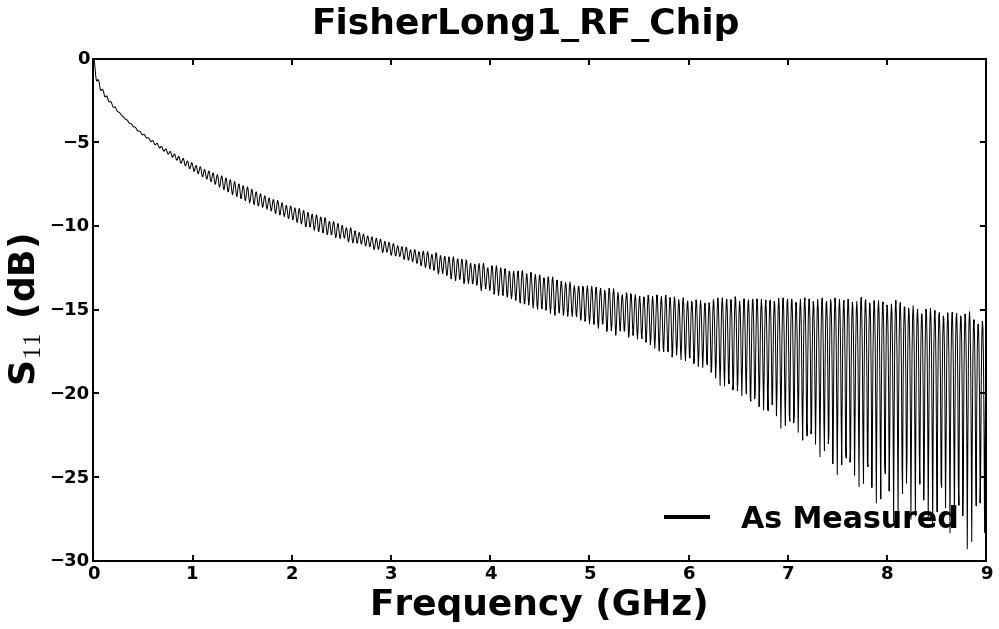

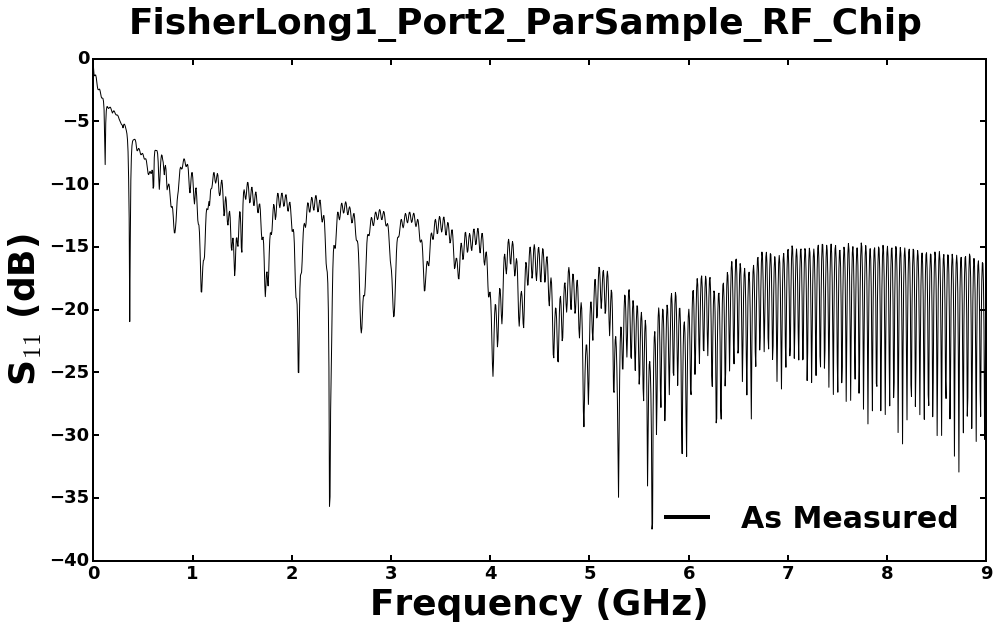

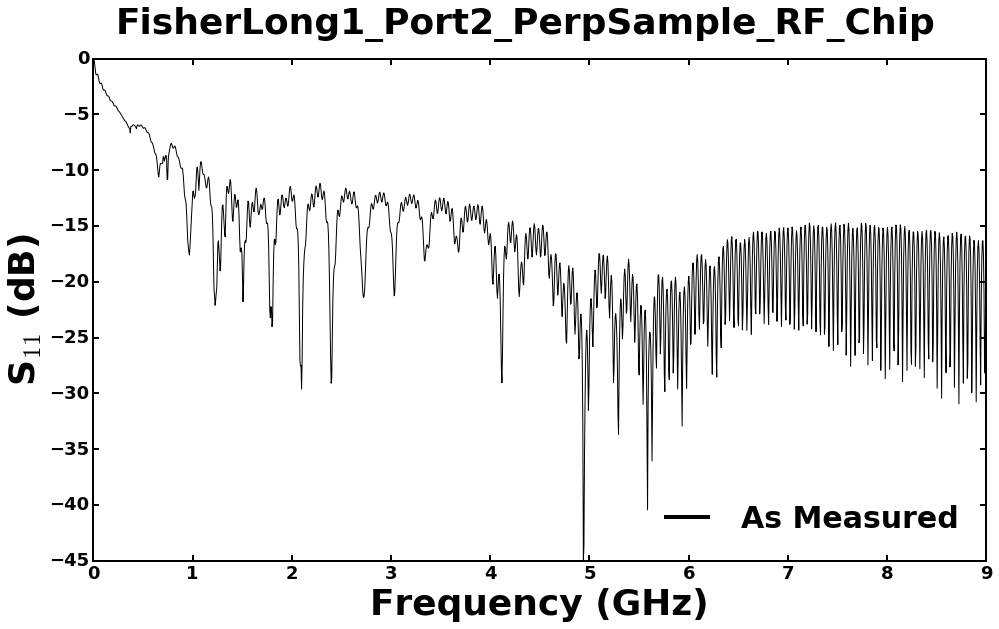

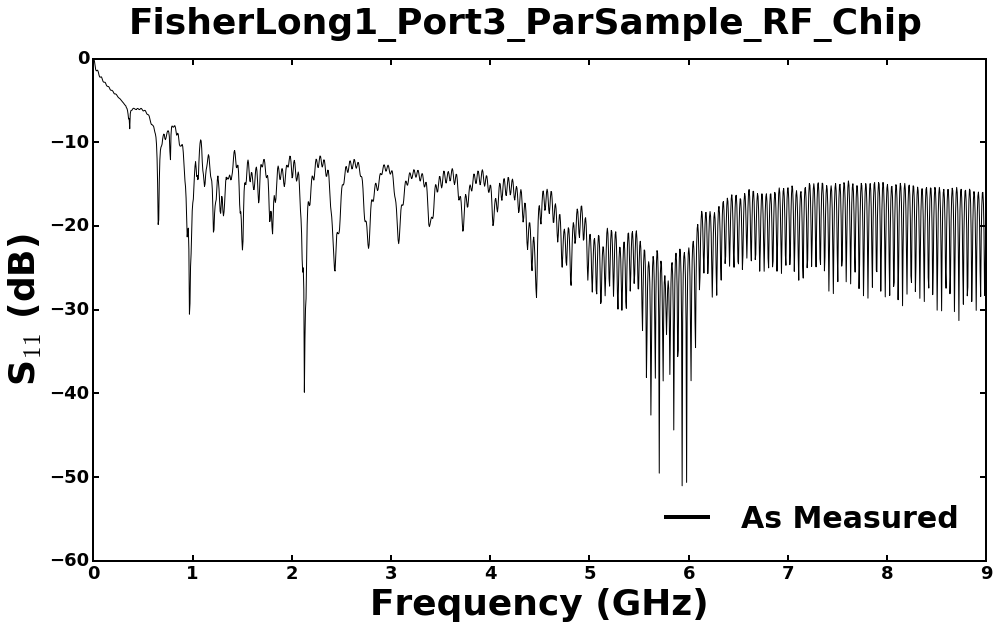

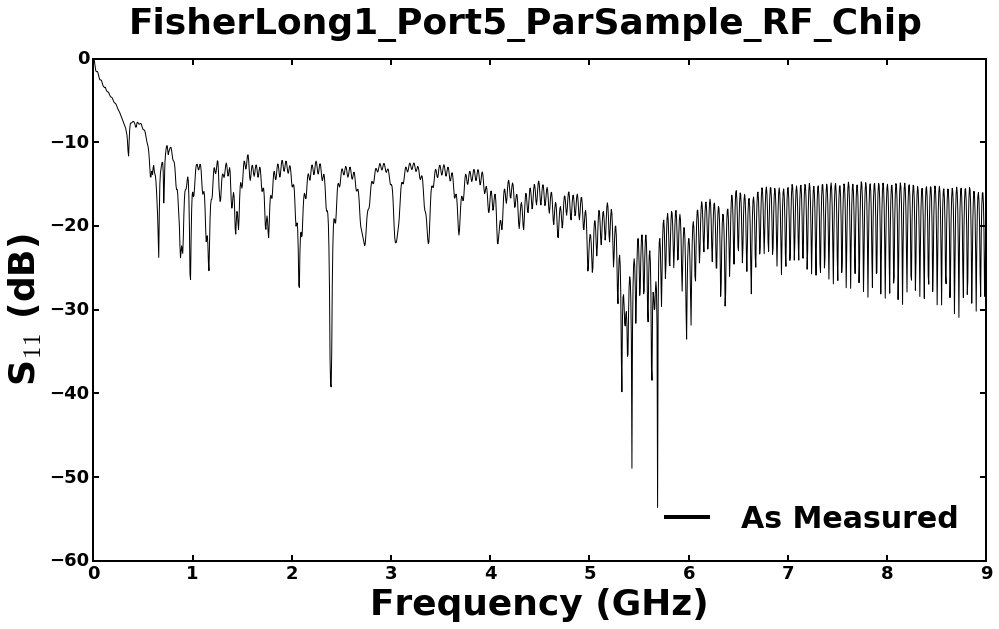

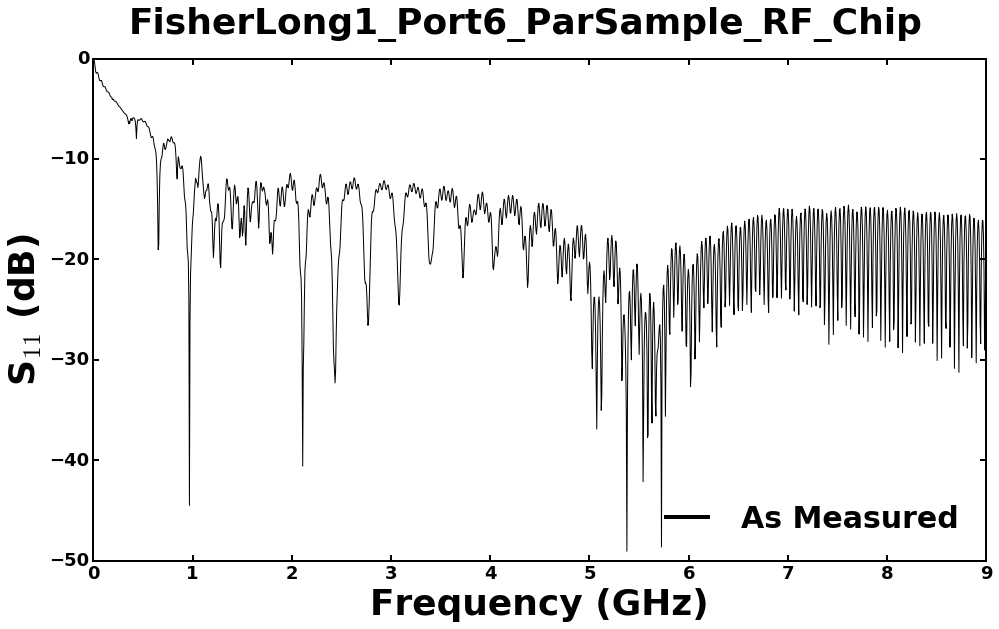

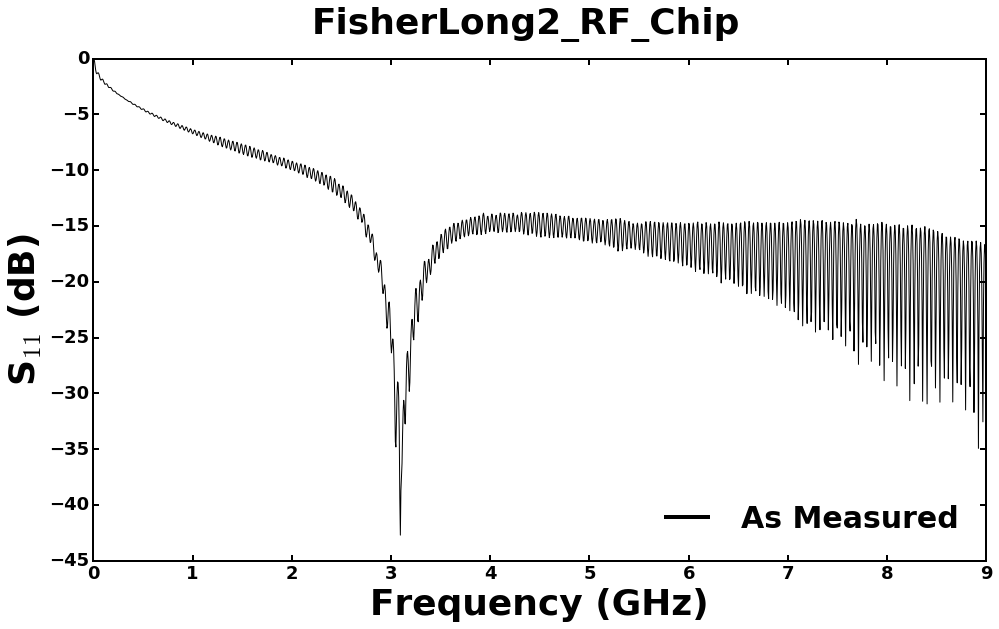

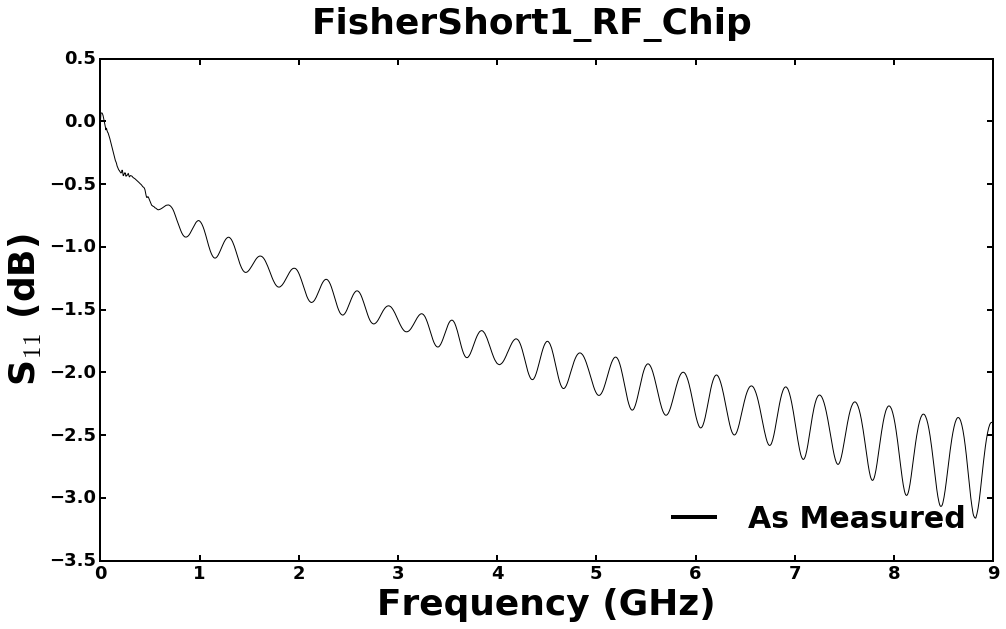

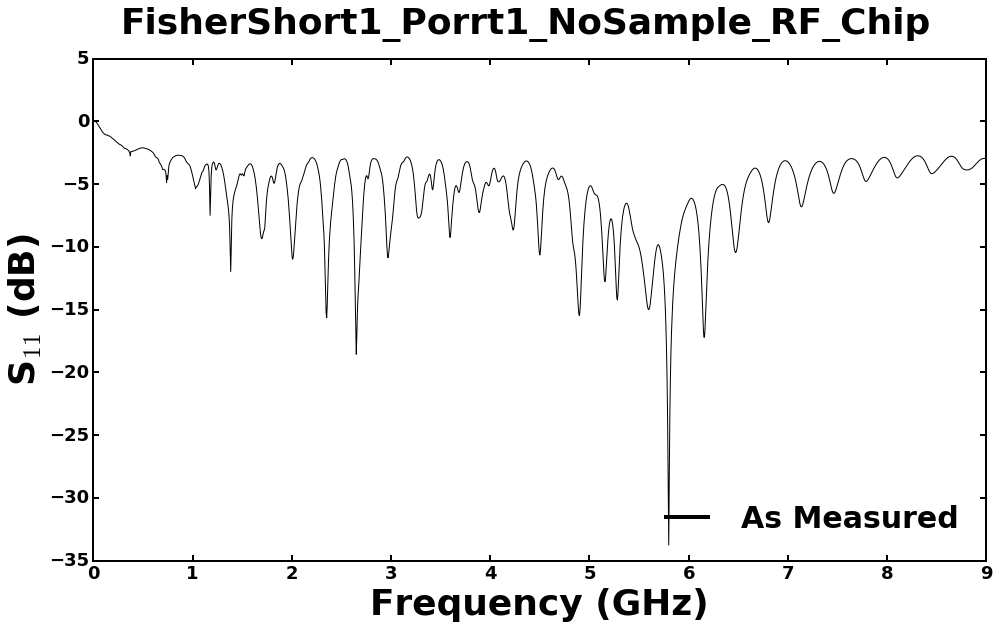

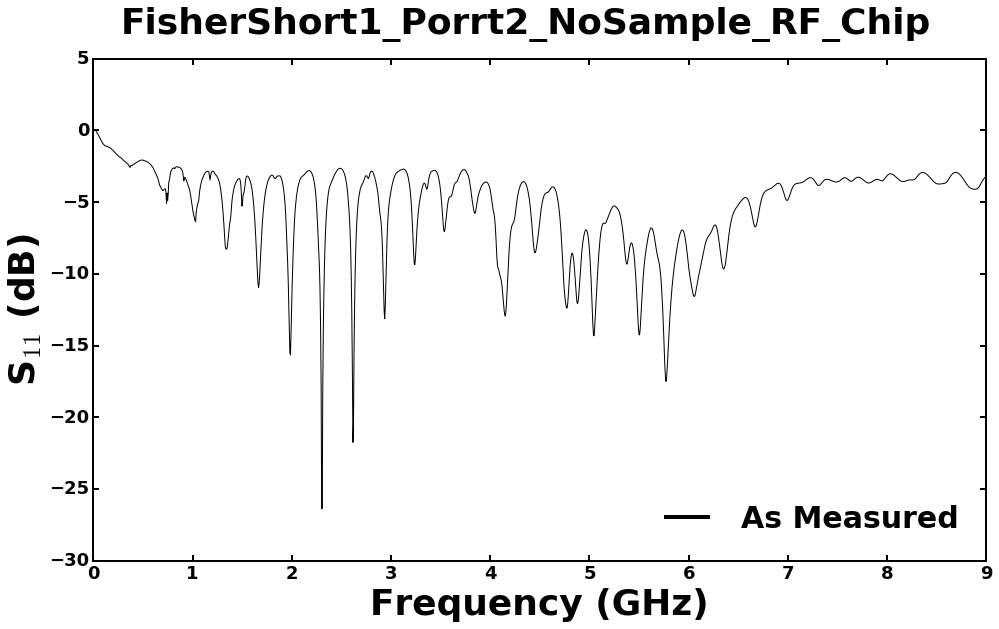

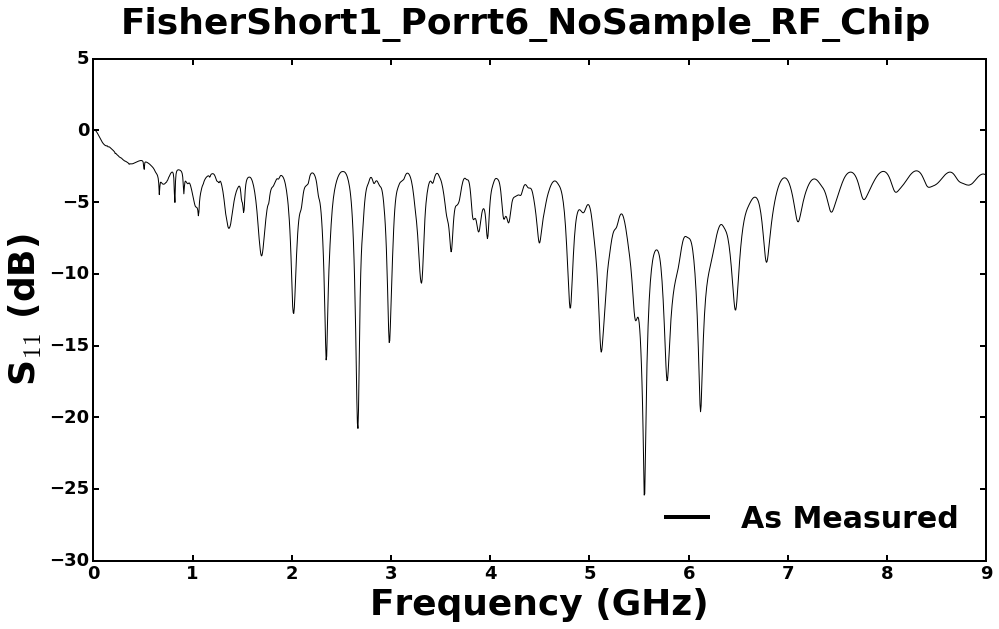

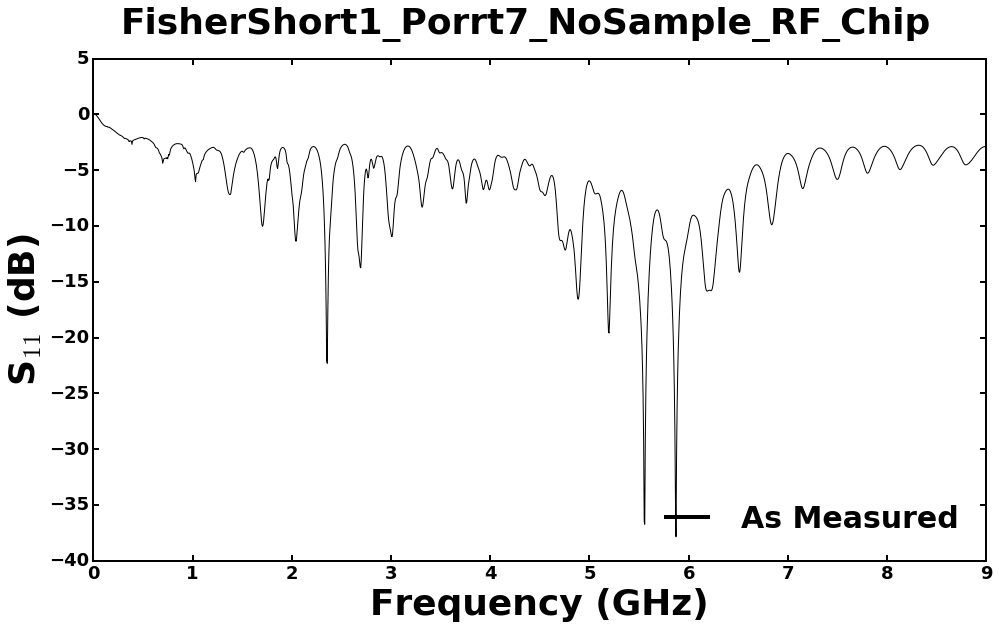

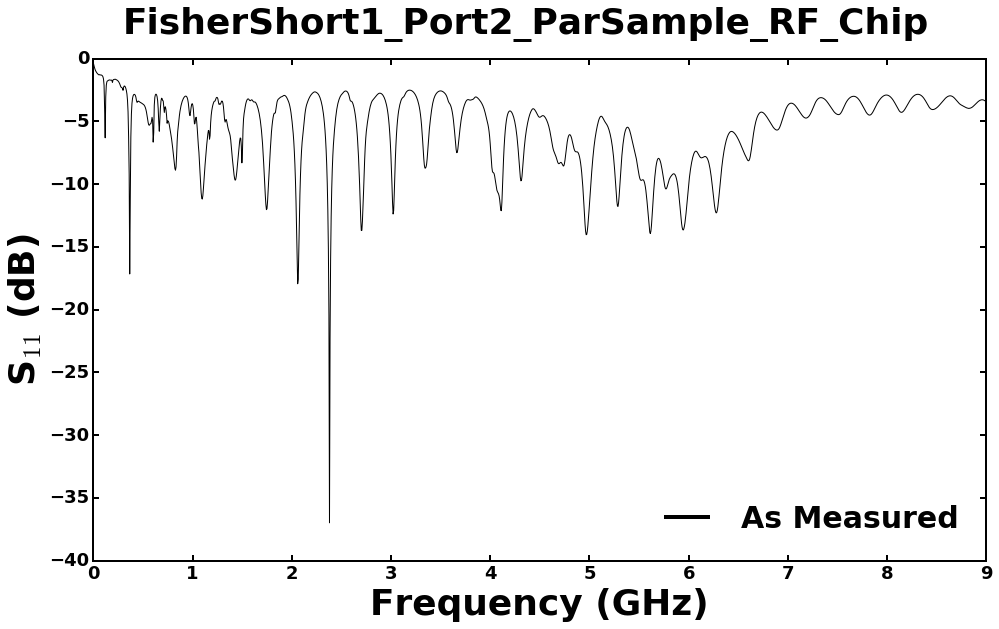

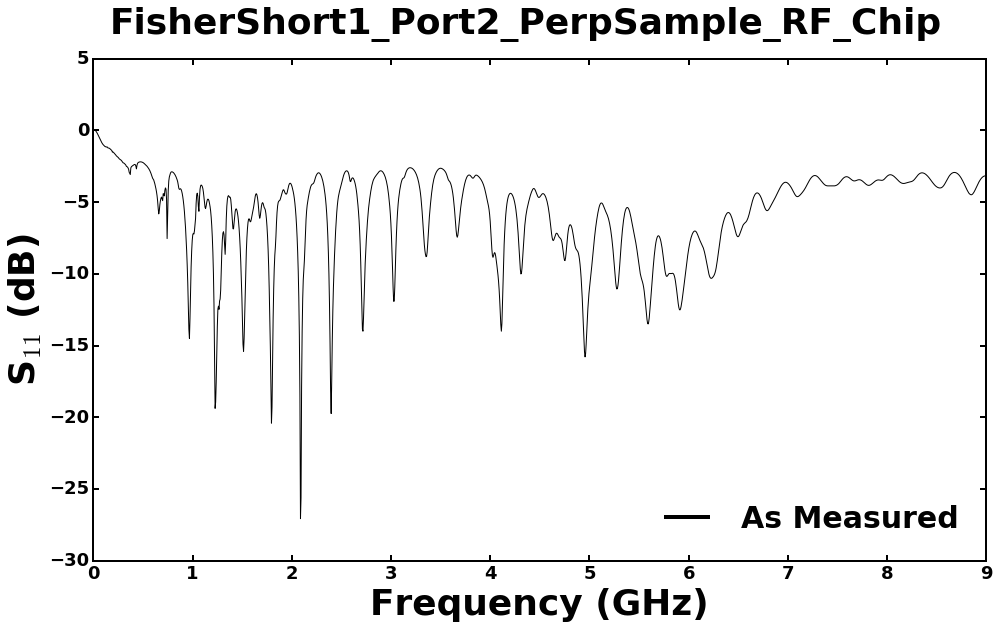

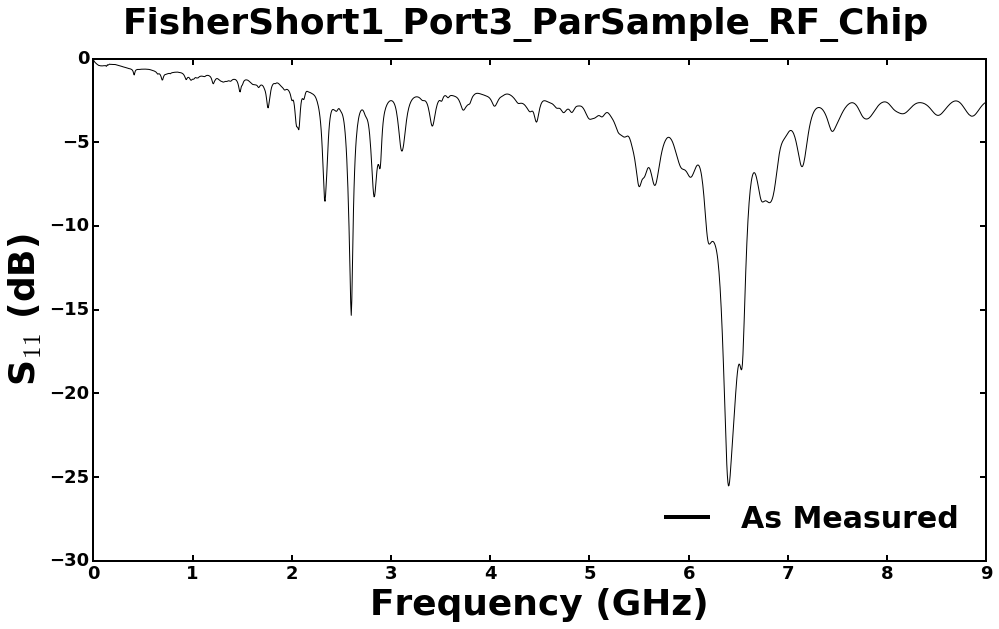

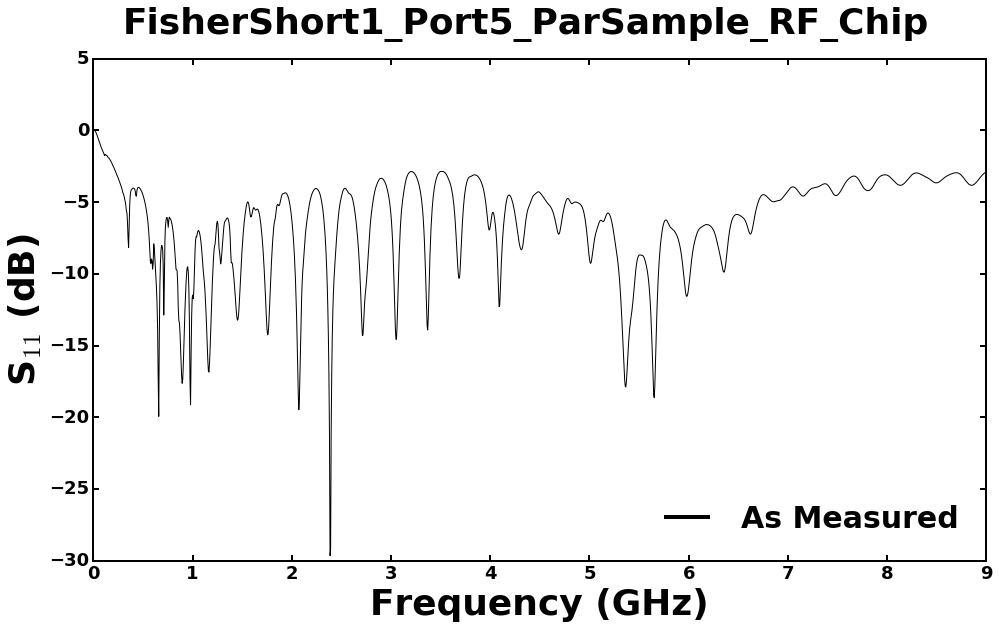

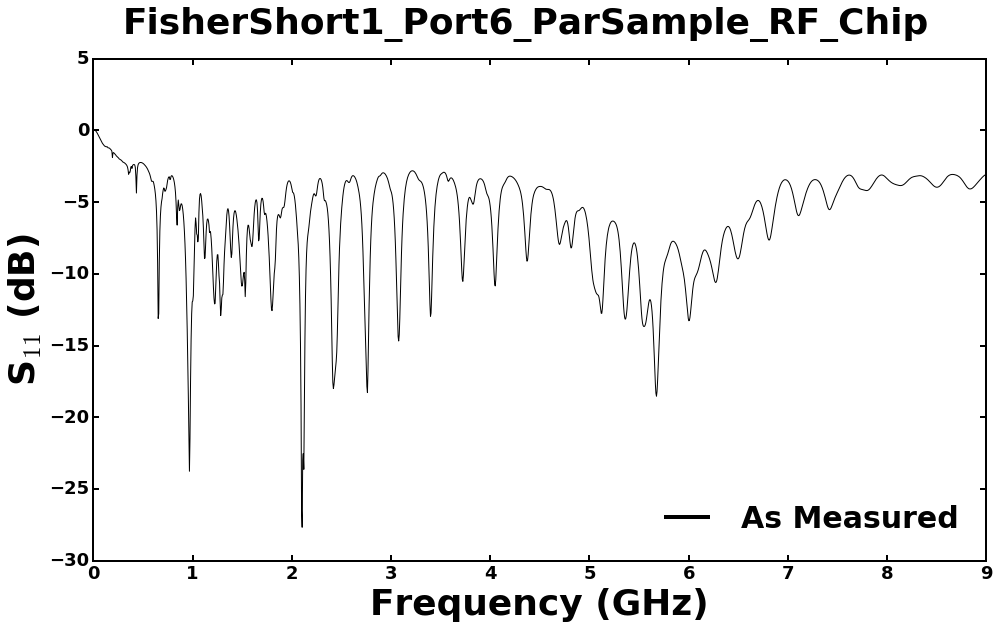

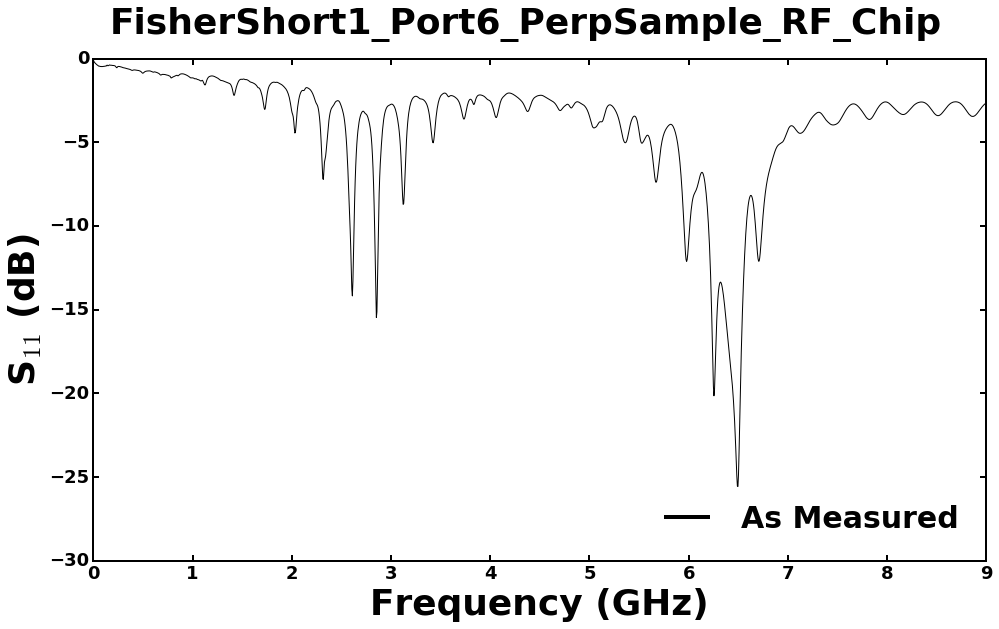

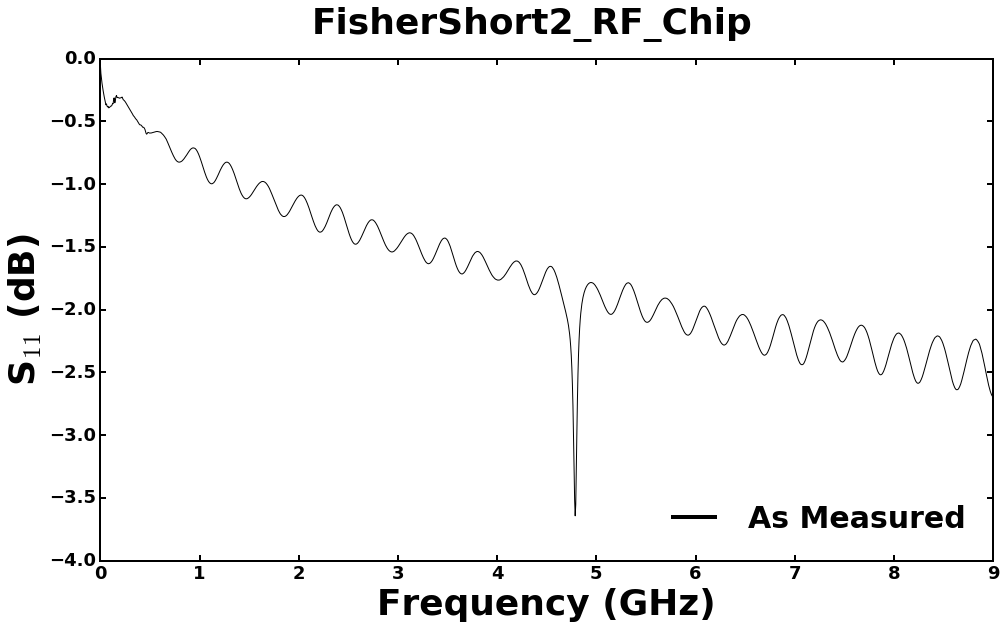

In [10]:
## RF data plotting
''' Opens all RF samples and subtracts cable results. Also plots filtered data'''
plot_file1=np.arange(data_array.shape[2])
#data_array_order=[2,4,6,8,10,12,14] #Used for plotting A experiments
#data_array_order=[3,5,7,9,11,13,15] #Used for plotting B experiments
a=0
for n in plot_file1:
  
    #X=data_A_2[:,0,plot_file[n]] #Used for plotting A experiments as data_A_R, R=1,2
    #Y=data_A_2[:,1,plot_file[n]] #Used for plotting A experiments as data_A_R, R=1,2
#     rfx_cable=data_array[:,0,0]
#     rfy_cable=data_array[:,1,0]
#     rfy_cable_filt=lowpass_filter(rfy_cable,9,3)
    
    rfx_orig=data_array[:,0,n]
    rfy_orig=data_array[:,1,n]
    #x_filt=data_array[:,0,n] #Used for plotting B experiments as data_B_R, R=1,2
    rfy_orig_filt=lowpass_filter(rfy_orig,9,3) #Used for plotting B experiments as data_B_R, R=1,2
    
#     rfY_holder=rfy_orig-rfy_cable
#     rfY_holder_filt= rfy_orig_filt-rfy_cable_filt
    
    name_fix=plot_file1[n]+1
    plot_file_name=str(n+1)
    Data_Name = os.path.basename(file_list[n]).split('.')[0] + '_RF_Chip' #Change name whether R=1,2 and With to Without if A or B

    plt.rc('font', weight='bold')
    plt.rcParams['axes.linewidth']=2
    plt.rcParams['figure.figsize'] = (16,9)

    fig = plt.figure()
    fig.suptitle(Data_Name, fontsize=36, fontweight='bold')

    ax = fig.add_subplot(111)

    ax.set_xlabel('Frequency (GHz)', fontsize=36, fontweight='bold')
    ax.set_ylabel(r'S$_{11}$ (dB)', fontsize=36, fontweight='bold')

    ax.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
    ax.xaxis.get_offset_text().set_visible(False)

    #fig=plt.plot(X,Y,'k-',label='Chip')
#     fig=plt.plot(rfx_cable,rfy_cable,'g-',linewidth=1, label='Cable')  
#     fig=plt.plot(rfx_orig,rfY_holder,'b-',linewidth=1, label='Holder+Carrier')
    ax.plot(rfx_orig,rfy_orig,'k-',linewidth=1, label='As Measured')
    
#     fig=plt.plot(rfx_orig[:-1],rfY_holder_filt,'b-',linewidth=5)
#     fig=plt.plot(rfx_cable[:-1],rfy_cable_filt,'g-',linewidth=5)
#     fig=plt.plot(rfx_orig[:-1],rfy_orig_filt,'r-',linewidth=5)
    
    

    leg=plt.legend(fontsize=30, loc=4, frameon=False)

    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)

    save_loc=root.directory+'/'+Data_Name+'.png'
    fig.savefig(save_loc,dpi=600,bbox_inches='tight')

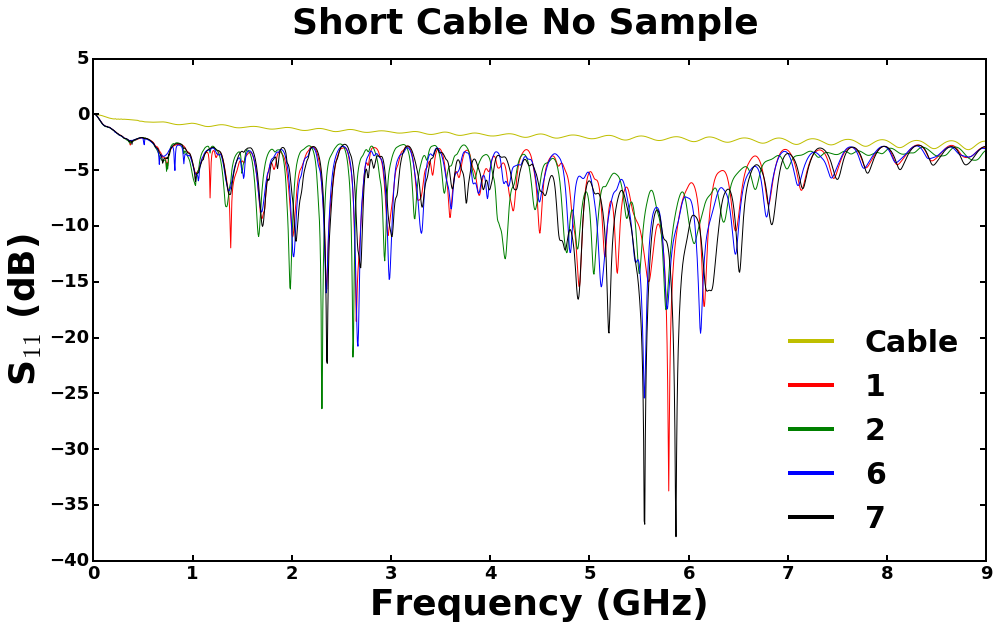

In [53]:
X=data_array[:,0,0]
ShortCableY=data_array[:,1,7]
NoSample_Port1=data_array[:,1,8]
NoSample_Port2=data_array[:,1,9]
NoSample_Port6=data_array[:,1,10]
NoSample_Port7=data_array[:,1,11]


Data_Name = 'Short Cable No Sample' #Change name whether R=1,2 and With to Without if A or B

plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=2
plt.rcParams['figure.figsize'] = (16,9)

fig = plt.figure()
fig.suptitle(Data_Name, fontsize=36, fontweight='bold')

ax = fig.add_subplot(111)

ax.set_xlabel('Frequency (GHz)', fontsize=36, fontweight='bold')
ax.set_ylabel(r'S$_{11}$ (dB)', fontsize=36, fontweight='bold')

ax.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
ax.xaxis.get_offset_text().set_visible(False)


fig=plt.plot(X,ShortCableY,'y-',linewidth=1, label='Cable')
fig=plt.plot(X,NoSample_Port1,'r-',linewidth=1, label='1')
fig=plt.plot(X,NoSample_Port2,'g-',linewidth=1, label='2')
fig=plt.plot(X,NoSample_Port6,'b-',linewidth=1, label='6')
fig=plt.plot(X,NoSample_Port7,'k-',linewidth=1, label='7')

leg=plt.legend(fontsize=30, loc=4, frameon=False)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

plt.show()

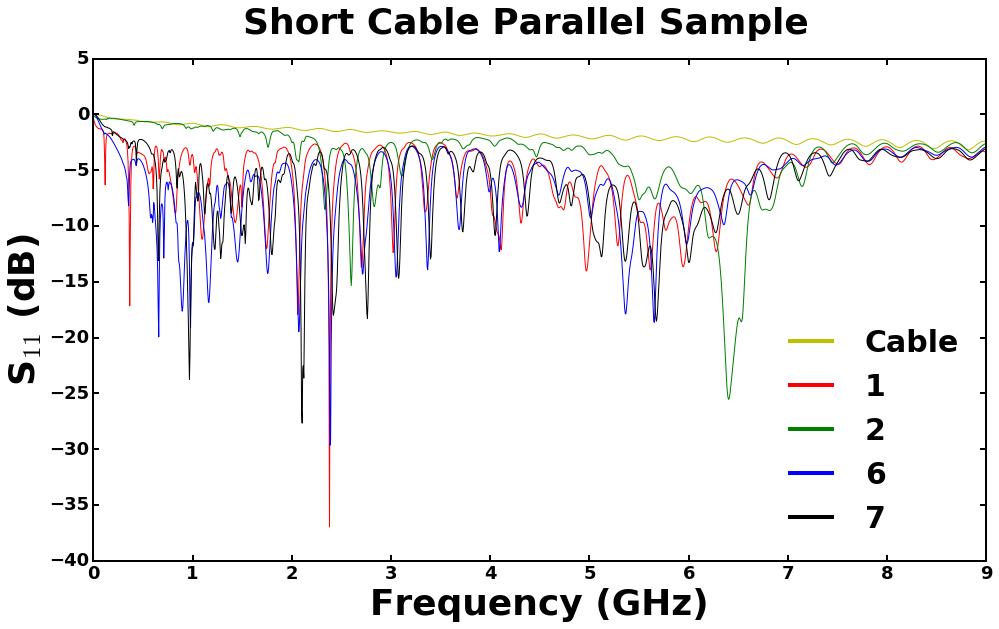

In [12]:
X=data_array[:,0,0]
ShortCableY=data_array[:,1,7]
ParSample_Port2=data_array[:,1,12]
ParSample_Port3=data_array[:,1,14]
ParSample_Port5=data_array[:,1,15]
ParSample_Port6=data_array[:,1,16]


Data_Name = 'Short Cable Parallel Sample' #Change name whether R=1,2 and With to Without if A or B

plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=2
plt.rcParams['figure.figsize'] = (16,9)

fig = plt.figure()
fig.suptitle(Data_Name, fontsize=36, fontweight='bold')

ax = fig.add_subplot(111)

ax.set_xlabel('Frequency (GHz)', fontsize=36, fontweight='bold')
ax.set_ylabel(r'S$_{11}$ (dB)', fontsize=36, fontweight='bold')

ax.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
ax.xaxis.get_offset_text().set_visible(False)


fig=plt.plot(X,ShortCableY,'y-',linewidth=1, label='Cable')
fig=plt.plot(X,ParSample_Port2,'r-',linewidth=1, label='1')
fig=plt.plot(X,ParSample_Port3,'g-',linewidth=1, label='2')
fig=plt.plot(X,ParSample_Port5,'b-',linewidth=1, label='6')
fig=plt.plot(X,ParSample_Port6,'k-',linewidth=1, label='7')

leg=plt.legend(fontsize=30, loc=4, frameon=False)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

plt.show()

In [ ]:
X=data_array[:,0,0]
ShortCableY=data_array[:,1,7]
ParSample_Port2=data_array[:,1,12]
ParSample_Port3=data_array[:,1,14]
ParSample_Port5=data_array[:,1,15]
ParSample_Port6=data_array[:,1,16]


Data_Name = 'Short Cable No Sample' #Change name whether R=1,2 and With to Without if A or B

plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=2
plt.rcParams['figure.figsize'] = (16,9)

fig = plt.figure()
fig.suptitle(Data_Name, fontsize=36, fontweight='bold')

ax = fig.add_subplot(111)

ax.set_xlabel('Frequency (GHz)', fontsize=36, fontweight='bold')
ax.set_ylabel(r'S$_{11}$ (dB)', fontsize=36, fontweight='bold')

ax.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
ax.xaxis.get_offset_text().set_visible(False)


fig=plt.plot(X,ShortCableY,'y-',linewidth=1, label='Cable')
fig=plt.plot(X,ParSample_Port2,'r-',linewidth=1, label='1')
fig=plt.plot(X,ParSample_Port3,'g-',linewidth=1, label='2')
fig=plt.plot(X,ParSample_Port5,'b-',linewidth=1, label='6')
fig=plt.plot(X,ParSample_Port6,'k-',linewidth=1, label='7')

leg=plt.legend(fontsize=30, loc=4, frameon=False)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

plt.show()

In [71]:
root2 = Tk(); # Tk() is a function in tkinter that opens a window
root2.directory = filedialog.askdirectory(); # opens explorer window so you can find the folder of choice
root2.withdraw(); # closes the tkinter window since it's unnecessary

In [77]:
file_name2='S11 Mean results_6frame'
ext2='.png'
file_loc2=root2.directory+'/'+file_name2+ext2
file_loc2

'Z:/Carrier Paper/Figure 3/S11 Mean results_6frame.png'

In [78]:
fig.savefig(file_loc2,dpi=600,bbox_inches='tight')

In [96]:
log10mean(By_orig_mean, axis=0)

-0.15809494512065558

In [94]:
-7.387061513255311/8

-0.9233826891569139